In [1]:
# Import required libraries
import sqlite3
import pandas as pd

# Step 1: Load the dataset
data_path = "Housing.csv"
data = pd.read_csv(data_path)

# Inspect the dataset
print("Dataset Columns:")
print(data.columns)

# Step 2: Create SQLite database and tables
conn = sqlite3.connect("housing.db")
cursor = conn.cursor()

# Table: PropertyDetails
cursor.execute("""
CREATE TABLE IF NOT EXISTS PropertyDetails (
    Area REAL,
    Bedrooms INTEGER,
    Bathrooms INTEGER,
    Stories INTEGER,
    Parking INTEGER,
    Price REAL
)
""")

# Table: Amenities
cursor.execute("""
CREATE TABLE IF NOT EXISTS Amenities (
    RowID INTEGER PRIMARY KEY AUTOINCREMENT,
    MainRoad BOOLEAN,
    GuestRoom BOOLEAN,
    Basement BOOLEAN,
    HotWaterHeating BOOLEAN,
    AirConditioning BOOLEAN,
    PrefArea BOOLEAN
)
""")

# Table: Furnishing
cursor.execute("""
CREATE TABLE IF NOT EXISTS Furnishing (
    RowID INTEGER PRIMARY KEY AUTOINCREMENT,
    FurnishingStatus TEXT
)
""")

conn.commit()
print("Database schema created successfully.")

# Step 3: Populate the PropertyDetails table
property_details = data[['area', 'bedrooms', 'bathrooms', 'stories', 'parking', 'price']]
property_details.to_sql('PropertyDetails', conn, if_exists='replace', index=True)  # Save with default rowid

# Step 4: Populate the Amenities table
amenities = data[['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']]
amenities.to_sql('Amenities', conn, if_exists='replace', index=True)

# Step 5: Populate the Furnishing table
furnishing = data[['furnishingstatus']]
furnishing.to_sql('Furnishing', conn, if_exists='replace', index=True)

print("Data populated successfully into normalized database.")

# Step 6: Verify the database with a joined query
query = """
SELECT pd.rowid AS PropertyID, pd.Area, pd.Bedrooms, pd.Bathrooms, pd.Stories, pd.Parking, pd.Price,
       a.MainRoad, a.GuestRoom, a.Basement, a.HotWaterHeating, a.AirConditioning, a.PrefArea,
       f.FurnishingStatus
FROM PropertyDetails pd
JOIN Amenities a ON pd.rowid = a.rowid
JOIN Furnishing f ON pd.rowid = f.rowid
"""
result = pd.read_sql_query(query, conn)

print("Joined Data:")
print(result.head())

# Step 7: Close the connection
conn.close()


Dataset Columns:
Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')
Database schema created successfully.
Data populated successfully into normalized database.
Joined Data:
   PropertyID  area  bedrooms  bathrooms  stories  parking     price mainroad  \
0           1  7420         4          2        3        2  13300000      yes   
1           2  8960         4          4        4        3  12250000      yes   
2           3  9960         3          2        2        2  12250000      yes   
3           4  7500         4          2        2        3  12215000      yes   
4           5  7420         4          1        2        2  11410000      yes   

  guestroom basement hotwaterheating airconditioning prefarea furnishingstatus  
0        no       no              no             yes      yes        furnished  
1        no   

In [2]:
# Import necessary libraries
import sqlite3
import pandas as pd

# Step 1: Connect to the database
db_path = "housing.db"  # Path to the SQLite database
conn = sqlite3.connect(db_path)

# Step 2: SQL join query
query = """
SELECT 
    pd.rowid AS PropertyID,
    pd.Area,
    pd.Bedrooms,
    pd.Bathrooms,
    pd.Stories,
    pd.Parking,
    pd.Price,
    a.MainRoad,
    a.GuestRoom,
    a.Basement,
    a.HotWaterHeating,
    a.AirConditioning,
    a.PrefArea,
    f.FurnishingStatus
FROM PropertyDetails pd
JOIN Amenities a ON pd.rowid = a.rowid
JOIN Furnishing f ON pd.rowid = f.rowid
"""

# Step 3: Fetch data into Pandas DataFrame
df = pd.read_sql_query(query, conn)

# Step 4: Close the database connection
conn.close()

# Step 5: Display the DataFrame
print(df.head())


   PropertyID  area  bedrooms  bathrooms  stories  parking     price mainroad  \
0           1  7420         4          2        3        2  13300000      yes   
1           2  8960         4          4        4        3  12250000      yes   
2           3  9960         3          2        2        2  12250000      yes   
3           4  7500         4          2        2        3  12215000      yes   
4           5  7420         4          1        2        2  11410000      yes   

  guestroom basement hotwaterheating airconditioning prefarea furnishingstatus  
0        no       no              no             yes      yes        furnished  
1        no       no              no             yes       no        furnished  
2        no      yes              no              no      yes   semi-furnished  
3        no      yes              no             yes      yes        furnished  
4       yes      yes              no             yes       no        furnished  


Target Column: price
count    5.450000e+02
mean     4.766729e+06
std      1.870440e+06
min      1.750000e+06
25%      3.430000e+06
50%      4.340000e+06
75%      5.740000e+06
max      1.330000e+07
Name: price, dtype: float64


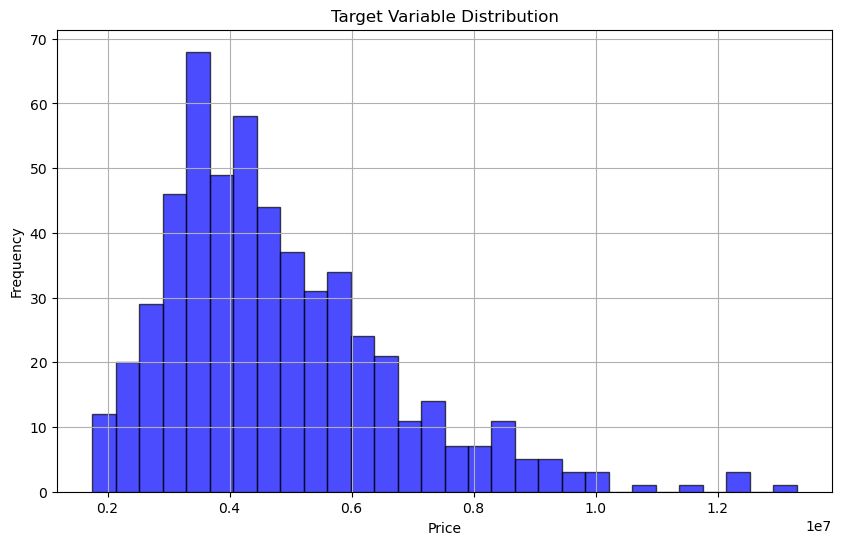


Distribution of furnishingstatus:
furnishingstatus
semi-furnished    227
unfurnished       178
furnished         140
Name: count, dtype: int64


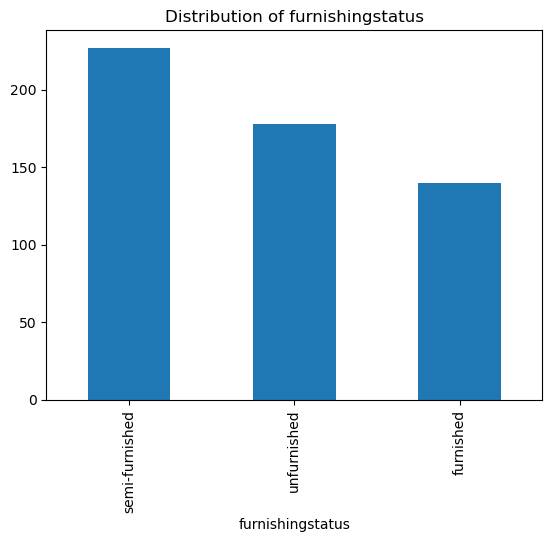

Data stratified by furnishingstatus
Training data size: (436, 12)
Testing data size: (109, 12)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Step 1: Load the dataset
data_path = "Housing.csv"
data = pd.read_csv(data_path)

# Step 2: Explore the target variable
target = 'price'  # Assuming 'price' is the target variable
print(f"Target Column: {target}")
print(data[target].describe())

# Plot the distribution of the target variable
plt.figure(figsize=(10, 6))
plt.hist(data[target], bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.title("Target Variable Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Check for categorical variables for potential stratification
categorical_features = ['furnishingstatus']
for feature in categorical_features:
    print(f"\nDistribution of {feature}:")
    print(data[feature].value_counts())
    data[feature].value_counts().plot(kind='bar', title=f"Distribution of {feature}")
    plt.show()

# Step 3: Determine the need for stratification
# If 'furnishingstatus' is imbalanced, stratify by it
stratify_col = 'furnishingstatus' if data['furnishingstatus'].nunique() > 1 else None

# Step 4: Perform train/test split
X = data.drop(columns=[target])  # Features
y = data[target]                 # Target variable

if stratify_col:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=data[stratify_col]
    )
    print(f"Data stratified by {stratify_col}")
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    print("Data split without stratification")

# Step 5: Output summary
print(f"Training data size: {X_train.shape}")
print(f"Testing data size: {X_test.shape}")

# Save the split datasets
X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)


Furnishingstatus column converted to numerical values.
Column 'mainroad' converted to numerical values.
Column 'guestroom' converted to numerical values.
Column 'basement' converted to numerical values.
Column 'hotwaterheating' converted to numerical values.
Column 'airconditioning' converted to numerical values.
Column 'prefarea' converted to numerical values.


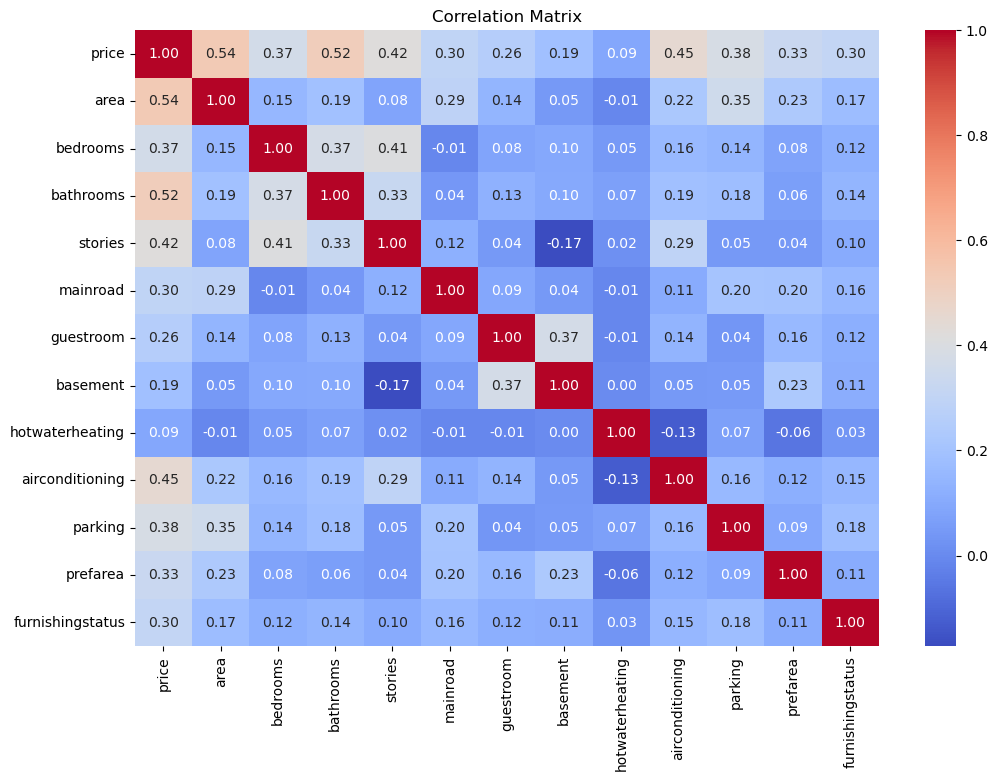


Top correlations (excluding self-correlations):
            Feature1         Feature2  Correlation
1               area            price     0.535997
13             price             area     0.535997
3          bathrooms            price     0.517545
39             price        bathrooms     0.517545
117            price  airconditioning     0.452954
9    airconditioning            price     0.452954
4            stories            price     0.420712
52             price          stories     0.420712
54          bedrooms          stories     0.408564
30           stories         bedrooms     0.408564


In [4]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure inline plotting for Jupyter Notebook
%matplotlib inline

# Load the dataset
data_path = "Housing.csv"
data = pd.read_csv(data_path)

# Step 1: Convert `furnishingstatus` to numerical values
if 'furnishingstatus' in data.columns:
    data['furnishingstatus'] = data['furnishingstatus'].map({
        'unfurnished': 0,
        'semi-furnished': 1,
        'furnished': 2
    })
    print("Furnishingstatus column converted to numerical values.")
else:
    print("Column 'furnishingstatus' not found in the dataset.")

# Convert `yes`/`no` values to `1`/`0`
for col in data.select_dtypes(include=['object']).columns:
    if data[col].str.lower().isin(['yes', 'no']).any():
        data[col] = data[col].map({'yes': 1, 'no': 0})
        print(f"Column '{col}' converted to numerical values.")

# Step 2: Correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Step 3: Extract and process top correlations
# Get the correlation matrix as a DataFrame
correlation_df = correlation_matrix.reset_index().melt(id_vars='index', var_name='Feature2', value_name='Correlation')

# Rename columns for clarity
correlation_df.rename(columns={'index': 'Feature1'}, inplace=True)

# Remove self-correlations
correlation_df = correlation_df[correlation_df['Feature1'] != correlation_df['Feature2']]

# Sort by absolute correlation values in descending order
correlation_df['AbsCorrelation'] = correlation_df['Correlation'].abs()
top_correlations = correlation_df.sort_values(by='AbsCorrelation', ascending=False).head(10)

# Display top correlations
print("\nTop correlations (excluding self-correlations):")
print(top_correlations[['Feature1', 'Feature2', 'Correlation']])


In [5]:
#Experiment1

import os
import mlflow

# Set up MLFlow tracking URI and authentication
MLFLOW_TRACKING_URI = "https://dagshub.com/sohithsaimalyala/Project.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME'] = 'sohithsaimalyala'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '29f357e14d4829f0c3e67f7e44b6391e7984e0cd'

# Configure MLFlow
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

# Experiment name
experiment_name = "Housing_Prediction"

# Set or create experiment
try:
    mlflow.set_experiment(experiment_name)
except mlflow.exceptions.MlflowException:
    print(f"Experiment '{experiment_name}' does not exist. Attempting to create it.")
    experiment_id = mlflow.create_experiment(experiment_name)
    mlflow.set_experiment(experiment_id)

# Start an MLflow run
with mlflow.start_run():
    mlflow.log_param("example_param", 42)
    mlflow.log_metric("example_metric", 0.99)
    print("Run logged successfully.")


Run logged successfully.
🏃 View run omniscient-carp-239 at: https://dagshub.com/sohithsaimalyala/Project.mlflow/#/experiments/0/runs/6fae8e30661b4740bb3b5a09d052d364
🧪 View experiment at: https://dagshub.com/sohithsaimalyala/Project.mlflow/#/experiments/0


In [6]:
#Experiment2

from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
import numpy as np
import mlflow
import pandas as pd

# Function to convert categorical values like 'yes'/'no' and 'furnished' to integers
def preprocess_categorical_columns(df):
    for col in df.columns:
        if df[col].dtype == 'object':  # Check for categorical columns
            # Convert 'yes'/'no' to 1/0
            if df[col].isin(['yes', 'no']).any():
                df[col] = df[col].map({'yes': 1, 'no': 0})
            
            # Convert 'furnished', 'semi-furnished', 'unfurnished' to 0, 1, 2
            if df[col].isin(['unfurnished', 'semi-furnished', 'furnished']).any():
                df[col] = df[col].map({'unfurnished': 0, 'semi-furnished': 1, 'furnished': 2})
    return df

# Apply conversion to training and test data
X_train = preprocess_categorical_columns(X_train)
X_test = preprocess_categorical_columns(X_test)

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X_train.select_dtypes(include=['float64', 'int64']).columns),  # Scale numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), X_train.select_dtypes(include=['object']).columns)  # One-hot encode categorical data
    ]
)

# Use XGBRegressor for regression tasks
regressor = XGBRegressor(objective='reg:squarederror', random_state=42)

# Create the pipeline with preprocessing and regression model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', regressor)
])

# Start the MLFlow run
name = "experiment2_housing"  # Set your run name
with mlflow.start_run(run_name=name):
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Predictions
    y_pred_test = pipeline.predict(X_test)
    
    # Log the model and metrics with MLFlow
    mlflow.sklearn.log_model(pipeline, "model")
    
    # Log evaluation metrics
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)
    mlflow.log_metric("RMSE", rmse)

    # Log hyperparameters
    mlflow.log_param("objective", "reg:squarederror")

    print("Model training and logging completed.")


2024/12/21 13:44:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model training and logging completed.
🏃 View run experiment2_housing at: https://dagshub.com/sohithsaimalyala/Project.mlflow/#/experiments/0/runs/0f85d24628a543c3b0da25f6a695962a
🧪 View experiment at: https://dagshub.com/sohithsaimalyala/Project.mlflow/#/experiments/0


In [7]:
#Experiment3

import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Assume you have already loaded the data (X_train, y_train, X_test, y_test)

# Step 1: Feature Engineering

# Example: Create new features by combining existing ones (e.g., ratios, differences, interaction terms)
def feature_engineering(df):
    # Combine existing features (e.g., creating a new ratio feature)
    if 'feature1' in df.columns and 'feature2' in df.columns:
        df['feature_ratio'] = df['feature1'] / (df['feature2'] + 1e-5)  # Avoid division by zero
    
    # Example of creating an interaction feature
    if 'feature3' in df.columns and 'feature4' in df.columns:
        df['interaction_feature'] = df['feature3'] * df['feature4']
    
    # Example: Create polynomial features (e.g., squared term)
    if 'feature5' in df.columns:
        df['feature5_squared'] = df['feature5'] ** 2
    
    return df

# Apply feature engineering to training and test data
X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)

# Step 2: Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X_train.select_dtypes(include=['float64', 'int64']).columns),  # Scale numerical features
        ('cat', OneHotEncoder(), X_train.select_dtypes(include=['object']).columns)  # Encode categorical features
    ]
)

# Step 3: Initialize the model (XGBRegressor for regression)
model = XGBRegressor(objective='reg:squarederror')

# Step 4: Create the pipeline with preprocessing and regression model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', model)
])

# Step 5: Start MLFlow run to log the model and results
with mlflow.start_run(run_name="feature_engineering_experiment"):
    # Step 6: Train the model
    pipeline.fit(X_train, y_train)
    
    # Step 7: Predictions
    y_pred_test = pipeline.predict(X_test)
    
    # Step 8: Log model
    mlflow.sklearn.log_model(pipeline, "model")
    
    # Step 9: Evaluate model performance (e.g., RMSE, MAE)
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)
    
    # Step 10: Log metrics in MLFlow
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("MSE", mse)
    
    # Step 11: Log parameters if applicable (e.g., model parameters, feature engineering steps)
    mlflow.log_param("model_type", "XGBRegressor")
    mlflow.log_param("feature_engineering_steps", "feature_ratio, interaction_feature, feature5_squared")

    # Log any other parameters relevant to the experiment
    # Example: Logging hyperparameters (optional)
    mlflow.log_param("learning_rate", model.get_params().get('learning_rate'))
    mlflow.log_param("max_depth", model.get_params().get('max_depth'))


2024/12/21 13:44:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run feature_engineering_experiment at: https://dagshub.com/sohithsaimalyala/Project.mlflow/#/experiments/0/runs/1e1c1cd356bc4a73a976eb8cce44a8ac
🧪 View experiment at: https://dagshub.com/sohithsaimalyala/Project.mlflow/#/experiments/0


In [8]:
#Experiment4


import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression

# Assuming X_train, X_test, y_train, y_test are already loaded

# Step 1: Perform Correlation Threshold feature selection

def correlation_threshold(X, threshold=0.9):
    # Compute the correlation matrix
    corr_matrix = X.corr().abs()
    
    # Select upper triangle of correlation matrix to check for duplicate correlations
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Identify columns to drop
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    
    # Drop the correlated features
    X_filtered_corr = X.drop(columns=to_drop)
    
    return X_filtered_corr, to_drop

# Apply correlation threshold to X_train and X_test
X_train_corr, dropped_corr = correlation_threshold(X_train, threshold=0.9)
X_test_corr = X_test[X_train_corr.columns]  # Make sure test set has the same columns after dropping

# Step 2: Perform Feature Importance-based selection using XGBRegressor

# Train an XGBRegressor to get feature importances
model = XGBRegressor(objective='reg:squarederror')
model.fit(X_train_corr, y_train)

# Get the feature importances
feature_importances = model.feature_importances_

# Define the threshold for feature importance (e.g., keep features with importance > 0.01)
important_features = X_train_corr.columns[feature_importances > 0.01]
X_train_imp = X_train_corr[important_features]
X_test_imp = X_test_corr[important_features]

# Step 3: Perform Variance Threshold feature selection

# Variance threshold to remove features with low variance
variance_threshold = VarianceThreshold(threshold=0.01)  # 0.01 is a typical threshold, adjust as needed
X_train_var = variance_threshold.fit_transform(X_train_imp)
X_test_var = variance_threshold.transform(X_test_imp)

# Convert the result back to DataFrame
X_train_var_df = pd.DataFrame(X_train_var, columns=important_features[variance_threshold.get_support()])
X_test_var_df = pd.DataFrame(X_test_var, columns=important_features[variance_threshold.get_support()])

# Step 4: Create and train the model pipeline after feature selection

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X_train_var_df.select_dtypes(include=['float64', 'int64']).columns),  # Scale numerical features
        ('cat', OneHotEncoder(), X_train_var_df.select_dtypes(include=['object']).columns)  # Encode categorical features
    ]
)

# Create the pipeline with preprocessing and regression model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', model)
])

# Step 5: Start MLFlow run to log the model and results
with mlflow.start_run(run_name="feature_selection_experiment"):
    # Step 6: Train the model
    pipeline.fit(X_train_var_df, y_train)
    
    # Step 7: Predictions
    y_pred_test = pipeline.predict(X_test_var_df)
    
    # Step 8: Log model
    mlflow.sklearn.log_model(pipeline, "model")
    
    # Step 9: Evaluate model performance (e.g., RMSE, MSE)
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)
    
    # Step 10: Log metrics in MLFlow
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("MSE", mse)
    
    # Step 11: Log feature selection details
    mlflow.log_param("feature_selection_method", "Correlation Threshold, Feature Importance, Variance Threshold")
    mlflow.log_param("correlation_threshold", 0.9)
    mlflow.log_param("feature_importance_threshold", 0.01)
    mlflow.log_param("variance_threshold", 0.01)

    # Log the dropped features for correlation and variance threshold
    mlflow.log_param("dropped_features_corr", str(dropped_corr))
    mlflow.log_param("remaining_features_after_importance", str(important_features.tolist()))
    mlflow.log_param("remaining_features_after_variance", str(X_train_var_df.columns.tolist()))


2024/12/21 13:44:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run feature_selection_experiment at: https://dagshub.com/sohithsaimalyala/Project.mlflow/#/experiments/0/runs/8c25028873dd4ca6bb170ffa85d7fe79
🧪 View experiment at: https://dagshub.com/sohithsaimalyala/Project.mlflow/#/experiments/0


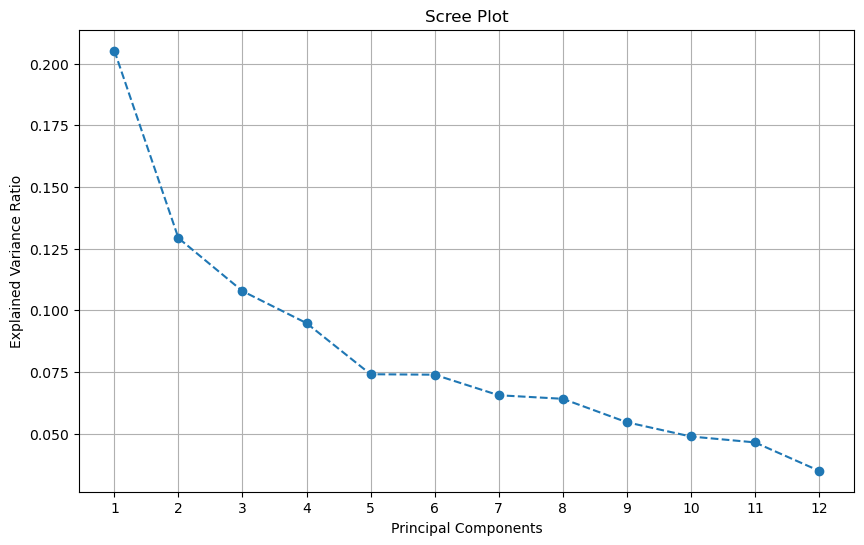

Number of components selected: 11


2024/12/21 13:44:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model trained with 11 components and logged to MLFlow.
🏃 View run pca_experiment at: https://dagshub.com/sohithsaimalyala/Project.mlflow/#/experiments/0/runs/6fe1953f729143bba3b02b8b85f394d2
🧪 View experiment at: https://dagshub.com/sohithsaimalyala/Project.mlflow/#/experiments/0


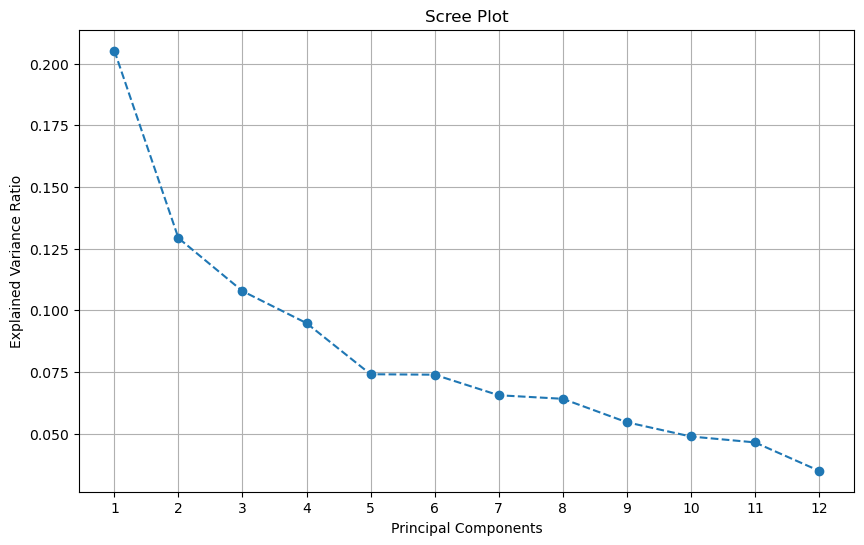

In [9]:
#Experiment5


import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Assuming you have already loaded the data (X_train, X_test, y_train, y_test)
# Example data: X_train, y_train, X_test, y_test

# Step 1: Preprocess the data (scaling features)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X_train.select_dtypes(include=['float64', 'int64']).columns),  # Scale numerical features
        ('cat', OneHotEncoder(), X_train.select_dtypes(include=['object']).columns)  # Encode categorical features
    ]
)

# Step 2: Apply PCA for dimensionality reduction
pca = PCA()

# Fit PCA on the training data (after preprocessing)
X_train_scaled = preprocessor.fit_transform(X_train)
pca.fit(X_train_scaled)

# Step 3: Plot the scree plot to show the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title("Scree Plot")
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.show()

# Step 4: Determine the number of components to select based on the cumulative variance (e.g., 95% explained variance)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
num_components = np.argmax(cumulative_variance >= 0.95) + 1  # Choose the number of components that explain 95% variance

print(f"Number of components selected: {num_components}")

# Step 5: Create the pipeline with PCA and XGBRegressor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=num_components)),
    ('regressor', XGBRegressor(objective='reg:squarederror'))
])

# Step 6: Start MLFlow run to log the model and results
with mlflow.start_run(run_name="pca_experiment"):
    # Step 7: Train the model
    pipeline.fit(X_train, y_train)
    
    # Step 8: Predictions
    y_pred_test = pipeline.predict(X_test)
    
    # Step 9: Log the model
    mlflow.sklearn.log_model(pipeline, "model")
    
    # Step 10: Evaluate model performance (e.g., RMSE, MSE)
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)
    
    # Step 11: Log metrics in MLFlow
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("MSE", mse)
    
    # Step 12: Log PCA details
    mlflow.log_param("num_components_selected", num_components)
    mlflow.log_param("explained_variance_threshold", 0.95)

    # Log the cumulative explained variance for analysis
    mlflow.log_metric("cumulative_explained_variance", cumulative_variance[-1])

    # Save the scree plot as an image and log it in MLFlow
    scree_plot_path = "scree_plot.png"
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
    plt.title("Scree Plot")
    plt.xlabel("Principal Components")
    plt.ylabel("Explained Variance Ratio")
    plt.grid(True)
    plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
    plt.savefig(scree_plot_path)
    mlflow.log_artifact(scree_plot_path)

    print(f"Model trained with {num_components} components and logged to MLFlow.")


In [10]:
#Experiment6

import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Assuming you have already loaded the data (X_train, X_test, y_train, y_test)
# Example data: X_train, y_train, X_test, y_test

# Step 1: Feature Engineering - Create new interaction and polynomial features
def feature_engineering(df):
    # Ensure feature3 and feature4 exist before applying PolynomialFeatures
    if 'feature3' in df.columns and 'feature4' in df.columns:
        # Create polynomial features (quadratic features for example)
        poly = PolynomialFeatures(degree=2, include_bias=False)
        poly_features = poly.fit_transform(df[['feature3', 'feature4']])
        poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(['feature3', 'feature4']))
        df = pd.concat([df, poly_df], axis=1)
    else:
        print("Warning: 'feature3' and/or 'feature4' are missing from the dataset.")

    # Create interaction terms between two features (make sure they exist)
    if 'feature1' in df.columns and 'feature2' in df.columns:
        df['feature_interaction'] = df['feature1'] * df['feature2']
    else:
        print("Warning: 'feature1' and/or 'feature2' are missing from the dataset.")
    
    return df

# Apply feature engineering to training and test data
X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)

# Step 2: Preprocessing pipeline for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X_train.select_dtypes(include=['float64', 'int64']).columns),  # Scale numerical features
        ('cat', OneHotEncoder(), X_train.select_dtypes(include=['object']).columns)  # Encode categorical features
    ]
)

# Step 3: Define models to compare: XGBRegressor, RandomForestRegressor, and LinearRegression
models = {
    'XGBRegressor': XGBRegressor(objective='reg:squarederror'),
    'RandomForestRegressor': RandomForestRegressor(),
    'LinearRegression': LinearRegression()
}

# Step 4: Define hyperparameter grid for GridSearchCV
param_grid = {
    'XGBRegressor': {
        'regressor__learning_rate': [0.01, 0.1, 0.2],
        'regressor__max_depth': [3, 6, 9],
        'regressor__n_estimators': [100, 200]
    },
    'RandomForestRegressor': {
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [10, 20, None],
        'regressor__min_samples_split': [2, 5]
    },
    'LinearRegression': {
        # Linear Regression doesn't have hyperparameters to tune, but can still be included for comparison
        'regressor__fit_intercept': [True, False]
    }
}

# Step 5: Train models using GridSearchCV to optimize hyperparameters
best_models = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    # Create the pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Perform GridSearchCV with n_jobs=1 to avoid parallelism and serialization issues
    grid_search = GridSearchCV(pipeline, param_grid[model_name], cv=5, n_jobs=1, verbose=1, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    
    # Store the best model for later comparison
    best_models[model_name] = grid_search.best_estimator_
    
    # Log the model and hyperparameters in MLFlow
    with mlflow.start_run(run_name=f'{model_name}_experiment'):
        mlflow.sklearn.log_model(grid_search.best_estimator_, f'{model_name}_model')
        mlflow.log_params(grid_search.best_params_)
        
        # Step 6: Predictions and Evaluation
        y_pred_test = grid_search.best_estimator_.predict(X_test)
        mse = mean_squared_error(y_test, y_pred_test)
        rmse = np.sqrt(mse)
        
        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("MSE", mse)
        
        print(f"{model_name} RMSE: {rmse}")
        print(f"{model_name} MSE: {mse}")

# Step 7: Compare the models' performance (display results)
for model_name, best_model in best_models.items():
    print(f"Best {model_name} model: {best_model}")


Training XGBRegressor...
Fitting 5 folds for each of 18 candidates, totalling 90 fits


2024/12/21 13:45:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBRegressor RMSE: 1247155.9633579778
XGBRegressor MSE: 1555397996939.3657
🏃 View run XGBRegressor_experiment at: https://dagshub.com/sohithsaimalyala/Project.mlflow/#/experiments/0/runs/1e5c761d4de04a53b528daa88f936f30
🧪 View experiment at: https://dagshub.com/sohithsaimalyala/Project.mlflow/#/experiments/0
Training RandomForestRegressor...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


2024/12/21 13:45:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RandomForestRegressor RMSE: 1218467.8492007542
RandomForestRegressor MSE: 1484663899535.9119
🏃 View run RandomForestRegressor_experiment at: https://dagshub.com/sohithsaimalyala/Project.mlflow/#/experiments/0/runs/fbdcd96564454a28a8a5a75f13757b4b
🧪 View experiment at: https://dagshub.com/sohithsaimalyala/Project.mlflow/#/experiments/0
Training LinearRegression...
Fitting 5 folds for each of 2 candidates, totalling 10 fits


2024/12/21 13:45:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LinearRegression RMSE: 1171014.9900659015
LinearRegression MSE: 1371276106959.0432
🏃 View run LinearRegression_experiment at: https://dagshub.com/sohithsaimalyala/Project.mlflow/#/experiments/0/runs/369d6b5d19e74769b2e9c18d5c8a375b
🧪 View experiment at: https://dagshub.com/sohithsaimalyala/Project.mlflow/#/experiments/0
Best XGBRegressor model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom',
       'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea',
       'furnishingstatus'],
      dtype='object')),
                                                 ('cat', OneHotEncoder(),
                                                  Index([], dtype='object'))])),
                ('regressor',
                 XGBRegressor(base_scor...
                              feature_types=None, gamma=Non

In [11]:
#Experiment7



import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming X_train, X_test, y_train, y_test are already loaded
# Example data: X_train, y_train, X_test, y_test

# Step 1: Feature Engineering - Optional (You can add feature engineering here)
def feature_engineering(df):
    # Example feature engineering: you can modify or create new features here if needed
    return df

# Apply feature engineering if necessary
X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)

# Step 2: Preprocessing pipeline for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X_train.select_dtypes(include=['float64', 'int64']).columns),  # Scale numerical features
        ('cat', OneHotEncoder(), X_train.select_dtypes(include=['object']).columns)  # Encode categorical features
    ]
)

# Step 3: Define models to compare: XGBRegressor, RandomForestRegressor, and LinearRegression
models = {
    'XGBRegressor': XGBRegressor(objective='reg:squarederror'),
    'RandomForestRegressor': RandomForestRegressor(),
    'LinearRegression': LinearRegression()
}

# Step 4: Define the number of features to select in RFE (e.g., select 10 features)
n_features_to_select = 10

# Step 5: Train models using RFE for feature selection and evaluate performance
best_models = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    # Create the pipeline with RFE for feature selection
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', RFE(estimator=model, n_features_to_select=n_features_to_select, step=1)),
        ('regressor', model)
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Step 6: Predictions and Evaluation
    y_pred_test = pipeline.predict(X_test)
    
    # Calculate RMSE, MAE, and R²
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)
    
    # Log the model and hyperparameters in MLFlow
    with mlflow.start_run(run_name=f'{model_name}_experiment_with_RFE'):
        mlflow.sklearn.log_model(pipeline, f'{model_name}_model')
        mlflow.log_param("n_features_to_select", n_features_to_select)
        mlflow.log_params({'model_type': model_name})
        
        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("R2", r2)
        
        print(f"{model_name} RMSE: {rmse}")
        print(f"{model_name} MAE: {mae}")
        print(f"{model_name} R²: {r2}")

    # Store the best model for later comparison
    best_models[model_name] = pipeline

# Step 7: Compare the models' performance (display results)
for model_name, best_model in best_models.items():
    print(f"Best {model_name} model: {best_model}")


Training XGBRegressor...


2024/12/21 13:45:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBRegressor RMSE: 1437312.2925403318
XGBRegressor MAE: 980436.6261467889
XGBRegressor R²: 0.4759676933465097
🏃 View run XGBRegressor_experiment_with_RFE at: https://dagshub.com/sohithsaimalyala/Project.mlflow/#/experiments/0/runs/5a0589b0cd784baebfd0905b0f15ee60
🧪 View experiment at: https://dagshub.com/sohithsaimalyala/Project.mlflow/#/experiments/0
Training RandomForestRegressor...


2024/12/21 13:46:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RandomForestRegressor RMSE: 1254502.258553809
RandomForestRegressor MAE: 878562.2006116207
RandomForestRegressor R²: 0.6007925132733493
🏃 View run RandomForestRegressor_experiment_with_RFE at: https://dagshub.com/sohithsaimalyala/Project.mlflow/#/experiments/0/runs/f0223f180e22455bb4afa8088cb12d18
🧪 View experiment at: https://dagshub.com/sohithsaimalyala/Project.mlflow/#/experiments/0
Training LinearRegression...


2024/12/21 13:46:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LinearRegression RMSE: 1198630.468797811
LinearRegression MAE: 873143.6059641269
LinearRegression R²: 0.6355596889672288
🏃 View run LinearRegression_experiment_with_RFE at: https://dagshub.com/sohithsaimalyala/Project.mlflow/#/experiments/0/runs/5735b31db6414624b7b2fb4a9cbf8ca9
🧪 View experiment at: https://dagshub.com/sohithsaimalyala/Project.mlflow/#/experiments/0
Best XGBRegressor model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom',
       'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea',
       'furnishingstatus'],
      dtype='object')),
                                                 ('cat', OneHotEncoder(),
                                                  Index([], dtype='object'))])),
                ('feature_selection',
                 RFE(estimator=...
            

Training XGBRegressor...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
2024/12/21 13:46:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBRegressor F1-Score: 0.6148201949278961
🏃 View run XGBRegressor_experiment_with_RFE at: https://dagshub.com/sohithsaimalyala/Project.mlflow/#/experiments/0/runs/4eabd50426684596bdc2e56add2be8d2
🧪 View experiment at: https://dagshub.com/sohithsaimalyala/Project.mlflow/#/experiments/0
Training RandomForestRegressor...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
2024/12/21 13:46:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RandomForestRegressor F1-Score: 0.6165952972318391
🏃 View run RandomForestRegressor_experiment_with_RFE at: https://dagshub.com/sohithsaimalyala/Project.mlflow/#/experiments/0/runs/379350c0648b4101a98f495cbc758082
🧪 View experiment at: https://dagshub.com/sohithsaimalyala/Project.mlflow/#/experiments/0
Training LinearRegression...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
2024/12/21 13:47:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LinearRegression F1-Score: 0.6697475639637586
🏃 View run LinearRegression_experiment_with_RFE at: https://dagshub.com/sohithsaimalyala/Project.mlflow/#/experiments/0/runs/b0c1796c1ad342c6b46a16600a618f4f
🧪 View experiment at: https://dagshub.com/sohithsaimalyala/Project.mlflow/#/experiments/0


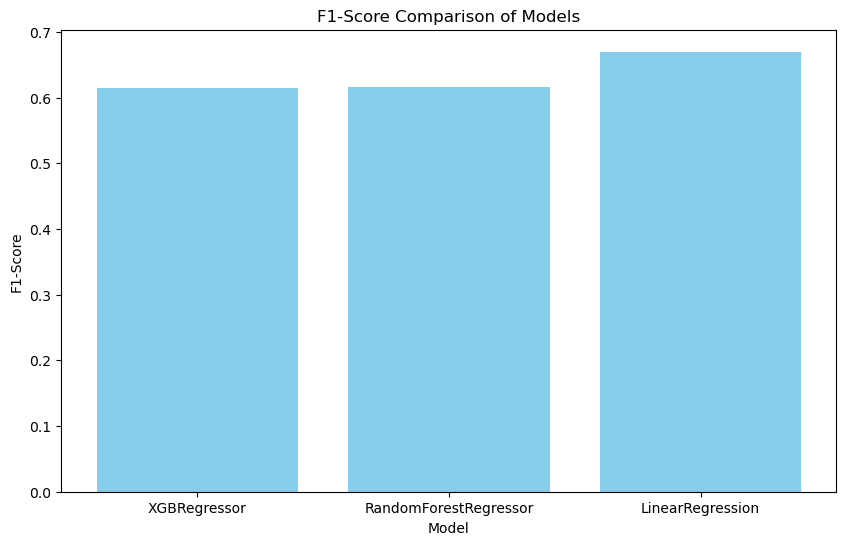

The best model based on F1-Score is: LinearRegression


In [12]:
#F1ScorePlots


import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import f1_score
from sklearn.preprocessing import KBinsDiscretizer

# Assuming you have already loaded the data (X_train, X_test, y_train, y_test)
# Example data: X_train, y_train, X_test, y_test

# Step 1: Feature Engineering - Optional (You can add feature engineering here if needed)
def feature_engineering(df):
    # Example feature engineering: you can modify or create new features here if needed
    return df

# Apply feature engineering if necessary
X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)

# Step 2: Preprocessing pipeline for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X_train.select_dtypes(include=['float64', 'int64']).columns),  # Scale numerical features
        ('cat', OneHotEncoder(), X_train.select_dtypes(include=['object']).columns)  # Encode categorical features
    ]
)

# Step 3: Define models to compare: XGBRegressor, RandomForestRegressor, and LinearRegression
models = {
    'XGBRegressor': XGBRegressor(objective='reg:squarederror'),
    'RandomForestRegressor': RandomForestRegressor(),
    'LinearRegression': LinearRegression()
}

# Step 4: Define the number of features to select in RFE (e.g., select 10 features)
n_features_to_select = 10

# Step 5: Train models using RFE for feature selection and evaluate F1-score
best_models = {}
f1_scores = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    # Create the pipeline with RFE for feature selection
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', RFE(estimator=model, n_features_to_select=n_features_to_select, step=1)),
        ('regressor', model)
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Step 6: Predictions and Evaluation (Convert y_test into categories for classification task)
    y_pred_test = pipeline.predict(X_test)

    # Convert continuous values into discrete classes (for demonstration purposes)
    discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
    y_test_binned = discretizer.fit_transform(y_test.values.reshape(-1, 1)).flatten()
    y_pred_test_binned = discretizer.transform(y_pred_test.reshape(-1, 1)).flatten()

    # Compute F1-score
    f1 = f1_score(y_test_binned, y_pred_test_binned, average='weighted')
    
    # Log the model and hyperparameters in MLFlow
    with mlflow.start_run(run_name=f'{model_name}_experiment_with_RFE'):
        mlflow.sklearn.log_model(pipeline, f'{model_name}_model')
        mlflow.log_param("n_features_to_select", n_features_to_select)
        mlflow.log_params({'model_type': model_name})
        
        mlflow.log_metric("F1-Score", f1)
        
        print(f"{model_name} F1-Score: {f1}")
        
    # Store the best model for later comparison
    best_models[model_name] = pipeline
    f1_scores[model_name] = f1

# Step 7: Compare the models' performance (F1-scores plot)
model_names = list(f1_scores.keys())
f1_values = list(f1_scores.values())

plt.figure(figsize=(10, 6))
plt.bar(model_names, f1_values, color='skyblue')
plt.xlabel("Model")
plt.ylabel("F1-Score")
plt.title("F1-Score Comparison of Models")
plt.show()

# Step 8: Log the best model based on F1-Score
best_model_name = max(f1_scores, key=f1_scores.get)
print(f"The best model based on F1-Score is: {best_model_name}")


In [13]:
import joblib

# Save the best model using joblib
best_model_name = max(f1_scores, key=f1_scores.get)  # Get the model with the best F1-score
best_model = best_models[best_model_name]

# Save the model to a file
joblib.dump(best_model, 'best_model.joblib')
print(f"Model saved as 'best_model.joblib'")


Model saved as 'best_model.joblib'


In [42]:
from fastapi import FastAPI
from pydantic import BaseModel

# Define your input model
class YourInputModel(BaseModel):
    size: float
    rooms: int
    location: str

app = FastAPI()

# Root endpoint
@app.get("/")
def root():
    return {"message": "Welcome to the FastAPI application"}

# Predict endpoint
@app.post("/predict")
def predict(data: YourInputModel):
    # Example prediction logic
    prediction = (data.size * 1000) + (data.rooms * 500)  # Replace with your actual model logic
    return {"prediction": prediction}


In [34]:
!pip install requests
